In [148]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [149]:
import sys
sys.path.append("../scripts")

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [151]:
plt.rcParams["figure.figsize"] = (14,6)

In [152]:
obs = pd.read_csv("../data/obs_arg.csv", parse_dates=["date"])
obs = obs.set_index("date")
#obs = obs.rename(columns={"I":"Is"})
obs

,I,R,D,Total_Confirmed
date,,,,
2020-03-03,1,0,0,1
2020-03-04,1,0,0,1
2020-03-05,1,0,0,1
2020-03-06,2,0,0,2
2020-03-07,8,0,0,8
...,...,...,...,...
2020-05-08,3659,1659,293,5611
2020-05-09,3748,1728,300,5776
2020-05-10,3972,1757,305,6034


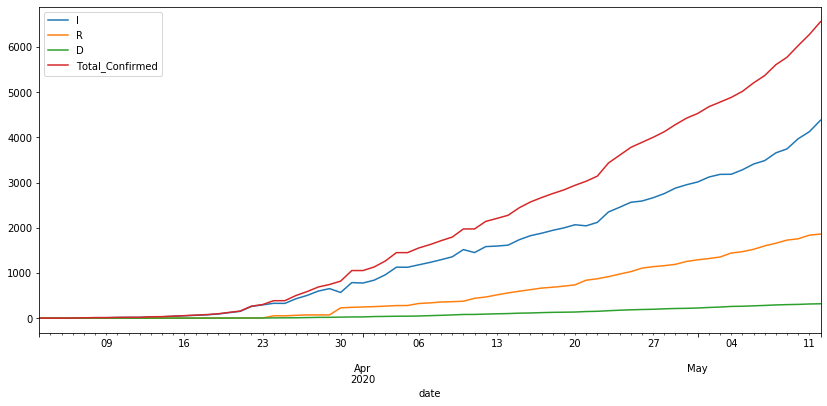

In [153]:
obs.plot()

In [154]:
obs = obs.rolling(window=7, min_periods=1).mean()

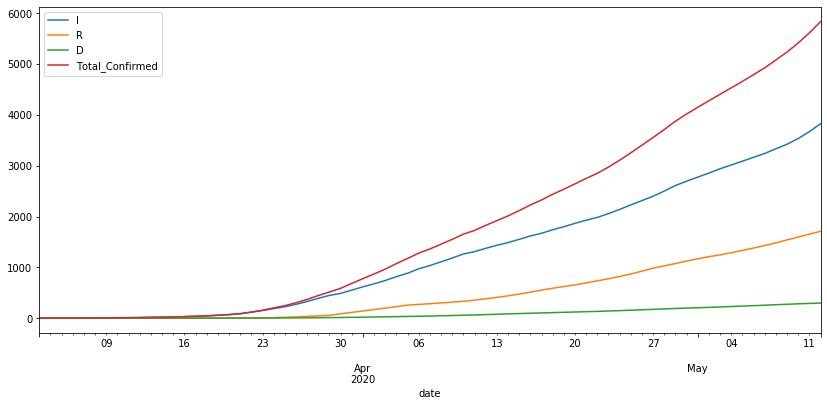

In [155]:
obs.plot()

In [156]:
recovery_rate = (obs.R / obs.Total_Confirmed).tail(5).mean() / 10
recovery_rate

0.029368486307299813

In [157]:
mortality_rate = (obs.D / obs.Total_Confirmed).tail(5).mean() / 10
mortality_rate

0.005188005991794689

In [158]:
target = obs["2020-04-01":"2020-04-30"].copy()
target = target.drop(columns=["Total_Confirmed"])
target.head()

,I,R,D
date,,,
2020-04-01,617.428571,142.142857,19.571429
2020-04-02,676.142857,169.714286,23.428571
2020-04-03,741.285714,197.428571,27.142857
2020-04-04,816.857143,227.000000,30.714286
2020-04-05,884.428571,256.714286,34.285714


In [159]:
test = obs["2020-05-01":"2020-05-15"].copy()
test = test.drop(columns=["Total_Confirmed"])
test.head()

,I,R,D
date,,,
2020-05-01,2775.714286,1168.428571,205.428571
2020-05-02,2855.571429,1209.857143,212.857143
2020-05-03,2939.857143,1245.142857,220.571429
2020-05-04,3014.000000,1288.285714,229.571429
2020-05-05,3089.142857,1332.571429,237.714286


In [160]:
from SEIR import SEIRD

In [161]:
model = SIRD2(population=44e6, recovery_rate=recovery_rate, mortality_rate=mortality_rate, incubation_rate=0.5, beta=0.05, initial_exposed=600)

In [162]:
target.head()

,I,R,D
date,,,
2020-04-01,617.428571,142.142857,19.571429
2020-04-02,676.142857,169.714286,23.428571
2020-04-03,741.285714,197.428571,27.142857
2020-04-04,816.857143,227.000000,30.714286
2020-04-05,884.428571,256.714286,34.285714


In [163]:
model.fit(target, estimate=('beta', "mortality_rate", "recovery_rate", "incubation_rate", "initial_exposed"), 
          weights=None, method="Nelder-Mead", options={"maxiter": 2000})

 final_simplex: (array([[8.78550279e-02, 4.06402508e-03, 2.14797387e-02, 7.54880115e-02,
        1.31394338e+03],
       [8.78550264e-02, 4.06402510e-03, 2.14797386e-02, 7.54880168e-02,
        1.31394331e+03],
       [8.78550299e-02, 4.06402509e-03, 2.14797386e-02, 7.54880058e-02,
        1.31394346e+03],
       [8.78550285e-02, 4.06402503e-03, 2.14797386e-02, 7.54880072e-02,
        1.31394345e+03],
       [8.78550274e-02, 4.06402507e-03, 2.14797387e-02, 7.54880154e-02,
        1.31394332e+03],
       [8.78550280e-02, 4.06402518e-03, 2.14797387e-02, 7.54880109e-02,
        1.31394339e+03]]), array([222.86395444, 222.86395444, 222.86395444, 222.86395444,
       222.86395444, 222.86395444]))
           fun: 222.8639544434857
       message: 'Optimization terminated successfully.'
          nfev: 1189
           nit: 752
        status: 0
       success: True
             x: array([8.78550279e-02, 4.06402508e-03, 2.14797387e-02, 7.54880115e-02,
       1.31394338e+03])

In [164]:
y0 = np.concatenate(([model.initial_exposed], target.head(1).to_numpy().flatten()))
res = model.simulate(y0, until=60)

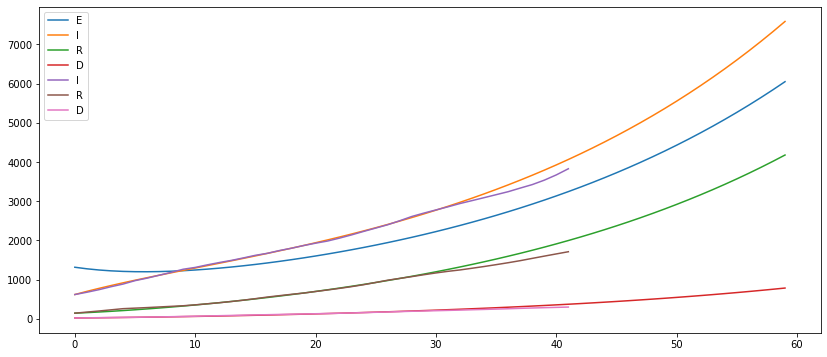

In [165]:
ax = res.plot()
pd.concat((target, test)).reset_index(drop=True).plot(ax=ax)